In [ ]:
import math
import types
import uuid

from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore
from langgraph_bigtool.utils import convert_positional_only_function_to_tool
from typing_extensions import Any

from utils import format_messages

load_dotenv()

True

In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini", max_tokens=2400, temperature=0)
embeddings = HuggingFaceEmbeddings(
    model_name="thenlper/gte-base", model_kwargs={"local_files_only": True}
)

In [ ]:
all_tools = []
for function_name in dir(math):
    function = getattr(math, function_name)

    # Only process builtin functions
    if not isinstance(function, types.BuiltinFunctionType):
        continue

    # Convert math functions to LangChain tools (handles positional-only parameters)
    if tool := convert_positional_only_function_to_tool(function):
        all_tools.append(tool)

# Create a tool registry mapping unique IDs to tool instances
# This allows for efficient tool lookup and management
tool_registry = {str(uuid.uuid4()): tool for tool in all_tools}

store = InMemoryStore(
    index={
        "embed": embeddings,
        "dims": 768,  # GTE-Base embedding dimensions
        "fields": ["description"],  # Index tool descriptions for search
    }
)

# Index all tools in the store for semantic similarity search
for tool_id, tool in tool_registry.items():
    store.put(
        ("tools",),  # Namespace
        tool_id,
        {
            "description": f"{tool.name}: {tool.description}",
        },
    )

/tmp/ipykernel_15296/3614452185.py:16: LangChainBetaWarning: The function `convert_positional_only_function_to_tool` is in beta. It is actively being worked on, so the API may change.
  if tool := convert_positional_only_function_to_tool(function):


In [ ]:
# Extended state class to store dynamically selected tools


class ToolLoadoutState(MessagesState):
    """State that extends MessagesState to include dynamically selected tools.

    This allows the agent to maintain context about which tools are currently
    available and bound to the conversation.
    """

    tools_by_name: dict[str, Any] = {}


# System prompt defining the agent's role and capabilities
system_prompt = """You are a helpful assistant with access to mathematical functions from Python's math library.
You can search for and use relevant mathematical tools to solve problems.
When you need to perform mathematical calculations, first determine what type of mathematical operation you need,
then use the appropriate tools from the math library."""


def llm_call(state: ToolLoadoutState, store: BaseStore) -> dict:
    """
    Main LLM call that dynamically selects and binds relevant tools.

        This function implements the core tool loadout pattern:
        1. Extract query context from a user message
        2. Search for semantically relevant tools
        3. Bind only relevant tools to the LLM
        4. Generate a response with a focused tool set

        Args:
            state: Current conversation state containing messages and tools
            store: Vector store containing indexed tool descriptions

        Returns:
            Dictionary with new messages and updated tool registry
    """

    # Extract user query for semantic tools
    messages = state["messages"]
    if messages and isinstance(messages[-1], HumanMessage):
        query = messages[-1].content

    else:
        query = "mathematical calculations"  # Default fallback

    # Perform semantic similarity search to find relevant tools
    search_results = store.search(("tools",), query=query, limit=5)

    # Build-focused tool set from search results
    relevant_tools = []
    tools_by_name = {}

    for result in search_results:
        tool_id = result.key
        if tool_id in tool_registry:
            tool = tool_registry[tool_id]
            relevant_tools.append(tool)
            tools_by_name[tool.name] = tool

    # Only bind relevant tools if exists else use llm to avoid context overload
    llm_with_tools = llm.bind_tools(relevant_tools) if relevant_tools else llm

    # Generate response with focused context
    response = llm_with_tools.invoke(
        [SystemMessage(content=system_prompt)] + state["messages"]
    )
    return {"messages": [response], "tools_by_name": tools_by_name}

In [ ]:
def tool_node(state: ToolLoadoutState):
    """Execute tool calls using the dynamically selected tool set."""
    # Create ToolNode with current tools from state
    current_tools = list(state["tools_by_name"].values())
    tool_executor = ToolNode(tools=current_tools)

    # Execute the ToolNode
    return tool_executor.invoke(state)

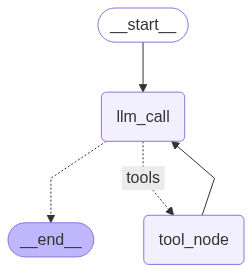

In [ ]:
agent_builder = StateGraph(ToolLoadoutState)

# Add workflow nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Define workflow edges
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    tools_condition,
    {
        "tools": "tool_node",
        END: END,
    },
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent with tool store for semantic search
agent = agent_builder.compile(store=store)

# Display the workflow graph
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
query = "Use available tools to calculate arc cosine of 0.5."
result = agent.invoke({"messages": [HumanMessage(content=query)]})
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Use available tools to calculate arc cosine of 0.5.                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 1.0471975511965979                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The arc cosine of 0.5 is approximately \( 1.0472 \) radians.                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯